In [78]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [753]:
!pip freeze > requirements.txt

In [190]:
# Function to calculate the precision of knn label predictions for the k nearest neighbors
def precision_at_k(knn_indices, cluster_labels, k):
    precision_scores = []
    for i, neighbors in enumerate(knn_indices):
        true_label = cluster_labels[i]
        retrieved_labels = [cluster_labels[j] for j in neighbors[1:k+1]]  
        relevant_count = sum(1 for label in retrieved_labels if label == true_label)
        precision_scores.append(relevant_count / k)
    return sum(precision_scores) / len(precision_scores)

### Method on Shot Data

In [737]:
shot_data = pd.read_csv("shot_data_with_poiu.csv")

In [738]:
shot_data = shot_data[shot_data.situation == '5on5']

In [739]:
offense_cols = [
    'shooting_poiu_id', 'xGoal', 'goal','shotDistance',
     'shotWasOnGoal'
]

defense_cols = [
    'defending_poiu_id', 'xGoal', 'goal', 'shotDistance',
    'shotWasOnGoal',
]

df_encoded = pd.get_dummies(shot_data, columns=['shotType'])

offensive_stats = (
    df_encoded[offense_cols + [col for col in df_encoded.columns if col.startswith('shotType_')]]
    .groupby(['shooting_poiu_id'])
    .agg(['mean', 'sum']) 
)

defensive_stats = (
    df_encoded[defense_cols + [col for col in df_encoded.columns if col.startswith('shotType_')]]
    .groupby(['defending_poiu_id'])
    .agg(['mean', 'sum'])
)

In [740]:
offensive_stats.columns = [f"{col[0]}_{col[1]}" for col in offensive_stats.columns]
offensive_stats['num_shots'] = shot_data.groupby('shooting_poiu_id').size()
offensive_stats.reset_index(inplace=True)

defensive_stats.columns = [f"{col[0]}_{col[1]}" for col in defensive_stats.columns]
defensive_stats['num_shots'] = shot_data.groupby('defending_poiu_id').size()
defensive_stats.reset_index(inplace=True)


In [741]:
offensive_stats.rename(columns={"shooting_poiu_id": "poiu_id"}, inplace=True)
defensive_stats.rename(columns={"defending_poiu_id": "poiu_id"}, inplace=True)


In [742]:
offensive_stats = offensive_stats.drop(columns=["shotDistance_sum"])
defensive_stats = defensive_stats.drop(columns=["shotDistance_sum"])

In [743]:
merged_df = pd.merge(
    offensive_stats, defensive_stats, 
    on = "poiu_id",
    how="outer", suffixes=('_offense', '_defense'))
merged_df.fillna(0, inplace=True)

In [744]:
merged_df["corsi"] = merged_df["num_shots_offense"] - merged_df["num_shots_defense"]

In [745]:
merged_df["total_shots"] = merged_df["num_shots_defense"] + merged_df["num_shots_offense"]

In [714]:
filtered_df = merged_df[merged_df.total_shots > 1]

In [746]:
cols = list(merged_df.columns)
cols = [col for col in cols if col not in ["poiu_id", "total_shots"]]

In [747]:
poiu_ids = merged_df['poiu_id']

In [748]:
X = merged_df[cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

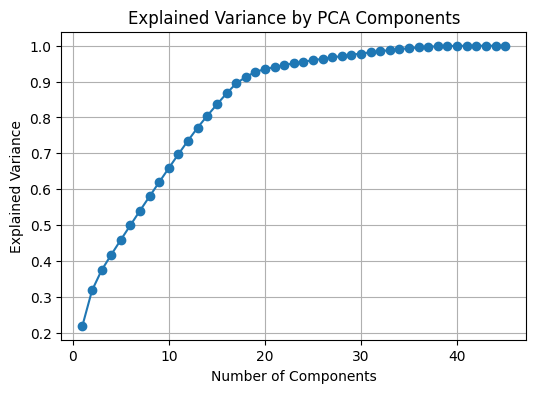

In [719]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.show()

In [749]:
pca = PCA(n_components=.9)
X_reduced = pca.fit_transform(X_scaled)

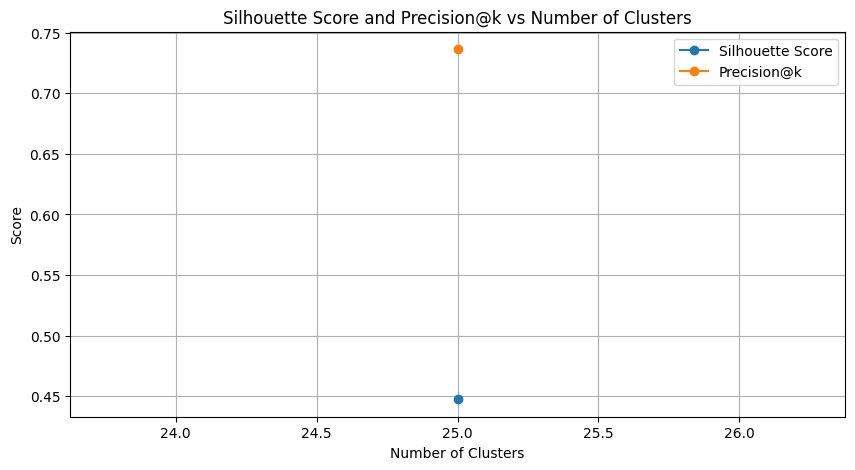

In [ ]:
sil_scores = []
prec_at_k_scores = []
k_values = [25]

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=5)
    cluster_labels = kmeans.fit_predict(X_reduced)

    sil = silhouette_score(X_scaled, cluster_labels, metric="cosine")
    sil_scores.append(sil)

    knn = NearestNeighbors(n_neighbors=6, metric="cosine")
    knn.fit(X_scaled)
    _, indices = knn.kneighbors(X_scaled)

    prec_k = precision_at_k(indices, cluster_labels, k=6)
    prec_at_k_scores.append(prec_k)

plt.figure(figsize=(10, 5))
plt.plot(k_values, sil_scores, label="Silhouette Score", marker='o')
plt.plot(k_values, prec_at_k_scores, label="Precision@k", marker='o')
plt.title("Silhouette Score and Precision@k vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

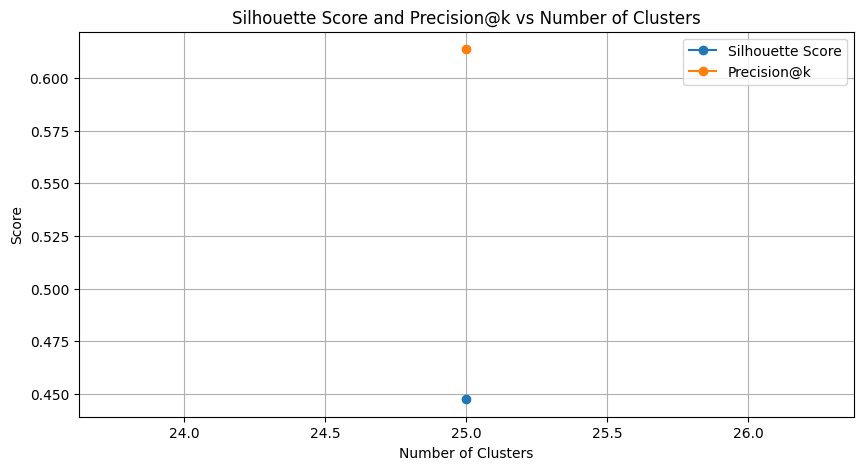

In [752]:
sil_scores = []
prec_at_k_scores = []
k_values = [25]

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=5)
    cluster_labels = kmeans.fit_predict(X_reduced)

    sil = silhouette_score(X_scaled, cluster_labels, metric="cosine")
    sil_scores.append(sil)

    knn = NearestNeighbors(n_neighbors=5, metric="cosine")
    knn.fit(X_scaled)
    _, indices = knn.kneighbors(X_scaled)

    prec_k = precision_at_k(indices, cluster_labels, k=6)
    prec_at_k_scores.append(prec_k)

plt.figure(figsize=(10, 5))
plt.plot(k_values, sil_scores, label="Silhouette Score", marker='o')
plt.plot(k_values, prec_at_k_scores, label="Precision@k", marker='o')
plt.title("Silhouette Score and Precision@k vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

In [723]:
knn = NearestNeighbors(n_neighbors=6, metric='cosine') 
knn.fit(X_reduced)
distances, indices = knn.kneighbors(X_reduced)

poiu_similarity_dict = {}

for i in range(len(poiu_ids)):
    neighbors = []
    for j in range(1,6): 
        neighbor_index = indices[i][j]
        neighbor_id = poiu_ids.iloc[neighbor_index]
        similarity = 1 - distances[i][j]
        similarity_pct = round(similarity * 100, 2)
        neighbors.append({'poiu_id': neighbor_id, 'similarity_pct': similarity_pct})
    
    poiu_similarity_dict[poiu_ids.iloc[i]] = neighbors

In [724]:
rows = []

for main_id, neighbors in poiu_similarity_dict.items():
    row = {'poiu_id': main_id}
    for idx, neighbor in enumerate(neighbors, start=1):
        row[f'neighbor_{idx}'] = neighbor['poiu_id']
        row[f'similarity_{idx}'] = neighbor['similarity_pct']
    rows.append(row)

poiu_neighbors_df = pd.DataFrame(rows)

In [727]:
poiu_neighbors_df.to_csv('similarity_penalty_kill_2023.csv', index=False)

### Method on MoneyPuck Data

In [ ]:
lines = pd.read_csv("lines.csv") 

In [313]:
feature_columns = [
    "xGoalsPercentage", "corsiPercentage", "fenwickPercentage", "xOnGoalFor",
    "xGoalsFor", "shotsOnGoalFor", "blockedShotAttemptsFor", "hitsFor", 
    "takeawaysFor", "giveawaysFor"
]

In [ ]:
# Filter the lines to used features and scale the dataframe
X = lines[feature_columns]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Baseline values of 5 clusters/neighbors more testing needed
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(X_scaled)  

num_neighbors = 5
knn = NearestNeighbors(n_neighbors=num_neighbors+1, metric='cosine') # use cosine similarity to "normalize" data
knn.fit(X_scaled)
_, indices = knn.kneighbors(X_scaled)

# Get the KNN label for each line combination and add to list
knn_labels = []
for i in range(len(lines)):
    knn_labels.append(cluster_labels[indices[i][0]])  

# Calculate silhoutte score from KNN
silhouette_knn = silhouette_score(X_scaled, knn_labels, metric="cosine")

#Calculate precision at k (function above)
precision_k = precision_at_k(indices, cluster_labels, num_neighbors)

print(silhouette_knn)
print(precision_k)

0.4444131485608894
0.9182496607869742


In [ ]:
# Finds the five most similar lines for each line and store in dictionary
similar_lines = {lines["lineId"].iloc[i]: list(lines["lineId"].iloc[indices[i][1:]]) for i in range(len(lines))}

num_lines = 0

# Print a few example similar lines
for line, similar in similar_lines.items():
    if num_lines < 5:
        print(f"Main Line")
        print(f"Players: {lines[lines["lineId"]==line].name.values[0]}")
        for sim in similar:
            print(f"    Similar Line")
            print(f"    Players: {lines[lines["lineId"]==sim].name.values[0]}")
        num_lines+= 1

Main Line
Players: Luostarinen-Lundell-Reinhart
    Similar Line
    Players: Necas-Drury-Noesen
    Similar Line
    Players: Bratt-Toffoli-Hughes
    Similar Line
    Players: Bertuzzi-Matthews-Domi
    Similar Line
    Players: Forsling-Montour
    Similar Line
    Players: Guentzel-Aho-Jarvis
Main Line
Players: Lindell-Hakanp
    Similar Line
    Players: Romanov-Dobson
    Similar Line
    Players: Dahlin-Samuelsson
    Similar Line
    Players: York-Sanheim
    Similar Line
    Players: Valimaki-Kesselring
    Similar Line
    Players: Gostisbehere-Maatta
Main Line
Players: Kunin-Granlund-Zadina
    Similar Line
    Players: Girgensons-Cozens-Okposo
    Similar Line
    Players: Eklund-Bordeleau-Hoffman
    Similar Line
    Players: Hirose-Juulsen
    Similar Line
    Players: Pyyhtia-Danforth-Olivier
    Similar Line
    Players: Zetterlund-Sturm-Hoffman
Main Line
Players: Krug-Leddy
    Similar Line
    Players: Lacombe-Lyubushkin
    Similar Line
    Players: Kubalik-Ostapchuk

### Similarity Merged MoneyPuck Data

In [287]:
lines_merged = pd.read_csv("linesMerged.csv")


In [430]:
X = lines_merged[feature_columns]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [432]:
# Baseline values of 5 clusters/neighbors more testing needed
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(X_scaled)  

num_neighbors = 5
knn = NearestNeighbors(n_neighbors=num_neighbors+1, metric='cosine') # use cosine similarity to "normalize" data
knn.fit(X_scaled)
_, indices = knn.kneighbors(X_scaled)

# Get the KNN label for each line combination and add to list
knn_labels = []
for i in range(len(lines_merged)):
    knn_labels.append(cluster_labels[indices[i][0]])  

# Calculate silhoutte score from KNN
silhouette_knn = silhouette_score(X_scaled, knn_labels, metric="cosine")

#Calculate precision at k (function above)
precision_k = precision_at_k(indices, cluster_labels, num_neighbors)

print(silhouette_knn)
print(precision_k)

0.22420530737938388
0.9350764134726333


In [ ]:
# Finds the five most similar lines for each line and store in dictionary
similar_lines = {lines_merged["lineId"].iloc[i]: list(lines_merged["lineId"].iloc[indices[i][1:]]) for i in range(len(lines))}

num_lines = 0

# Print a few example similar lines
for line, similar in similar_lines.items():
    if num_lines < 5:
        print(f"Main Line")
        print(f"Players: {lines_merged[lines_merged["lineId"]==line].name.values[0]}")
        for sim in similar:
            print(f"    Similar Line")
            print(f"    Players: {lines_merged[lines_merged["lineId"]==sim].name.values[0]}")
        num_lines+= 1

### Merge Data Together

In [607]:
lines = pd.read_csv("lines.csv")

In [608]:
lines = lines[lines.situation=='5on5']

In [609]:
d_lines = lines[lines.position == "pairing"].copy()
o_lines = lines[lines.position == "line"].copy()

In [610]:
o_lines.loc[:,'lineId'] = o_lines['lineId'].astype(str)
o_lines.loc[:,'player1_id'] = o_lines['lineId'].str[0:7].astype(int)
o_lines.loc[:,'player2_id'] = o_lines['lineId'].str[7:14].astype(int)
o_lines.loc[:,'player3_id'] = o_lines['lineId'].str[14:21].astype(int)

d_lines.loc[:,'lineId'] = d_lines['lineId'].astype(str)
d_lines.loc[:,'player1_id'] = d_lines['lineId'].str[0:7].astype(int)
d_lines.loc[:,'player2_id'] = d_lines['lineId'].str[7:14].astype(int)

In [611]:
shot_data = pd.read_csv("shot_data_with_poiu.csv")
shot_data = shot_data[shot_data.situation == '5on5']

In [612]:
shot_data["player_one_id"] = shot_data.player_one_id.astype(int)
shot_data["player_two_id"] = shot_data.player_two_id.astype(int)
shot_data["player_three_id"] = shot_data.player_three_id.astype(int)
shot_data["player_four_id"] = shot_data.player_four_id.astype(int)
shot_data["player_five_id"] = shot_data.player_five_id.astype(int)
shot_data["player_one_id.1"] = shot_data["player_one_id.1"].astype(int)
shot_data["player_two_id.1"] = shot_data["player_two_id.1"].astype(int)
shot_data["player_three_id.1"] = shot_data["player_three_id.1"].astype(int)
shot_data["player_four_id.1"] = shot_data["player_four_id.1"].astype(int)
shot_data["player_five_id.1"] = shot_data["player_five_id.1"].astype(int)

In [613]:
shot_data['offense_set'] = shot_data[['player_one_id', 'player_two_id', 'player_three_id', "player_four_id", "player_five_id"]].apply(
    lambda row: tuple(sorted([row['player_one_id'], row['player_two_id'], row['player_three_id'], row["player_four_id"], row["player_five_id"]])),
    axis=1
)

shot_data['defense_set'] = shot_data[['player_one_id.1', 'player_two_id.1', 'player_three_id.1', "player_four_id.1", "player_five_id.1"]].apply(
    lambda row: tuple(sorted([row['player_one_id.1'], row['player_two_id.1'], row['player_three_id.1'], row["player_four_id.1"], row["player_five_id.1"]])),
    axis=1
)

In [614]:
o_lines['forward_set'] = o_lines[['player1_id', 'player2_id', 'player3_id']].apply(
    lambda row: tuple(sorted([row['player1_id'], row['player2_id'], row['player3_id']])),
    axis=1
)
d_lines['defense_set'] = d_lines[['player1_id', 'player2_id']].apply(
    lambda row: tuple(sorted([row['player1_id'], row['player2_id']])),
    axis=1
)

In [615]:
feature_columns = [
    "xGoalsPercentage", "corsiPercentage", "fenwickPercentage", "xOnGoalFor",
    "xGoalsFor", "shotsOnGoalFor", "blockedShotAttemptsFor", "hitsFor", 
    "takeawaysFor", "giveawaysFor"
]
id_columns = ["player1_id", "player2_id", "player3_id", "forward_set", "name"]
id_columns_def = ["player1_id", "player2_id", "defense_set", "name"]

In [616]:
o_lines = o_lines[feature_columns + id_columns].copy()
d_lines = d_lines[feature_columns + id_columns_def].copy()

In [618]:
offense_cols = [
    'shooting_poiu_id', 'xGoal', 'goal','shotDistance',"offense_set",
    'shotRebound', 'shotRush', 'shotWasOnGoal'
]

defense_cols = [
    'defending_poiu_id', 'xGoal', 'goal', 'shotDistance',"defense_set",
    'shotRebound', 'shotRush','shotWasOnGoal',
]

df_encoded = pd.get_dummies(shot_data, columns=['shotType'])

offensive_stats = (
    df_encoded[offense_cols + [col for col in df_encoded.columns if col.startswith('shotType_')]]
    .groupby(['shooting_poiu_id', "offense_set"])
    .agg(['mean', 'sum']) 
)

defensive_stats = (
    df_encoded[defense_cols + [col for col in df_encoded.columns if col.startswith('shotType_')]]
    .groupby(['defending_poiu_id', "defense_set"])
    .agg(['mean', 'sum'])
)

In [619]:
offensive_stats.columns = [f"{col[0]}_{col[1]}" for col in offensive_stats.columns]
offensive_stats['num_shots'] = shot_data.groupby('shooting_poiu_id').size()
offensive_stats.reset_index(inplace=True)

defensive_stats.columns = [f"{col[0]}_{col[1]}" for col in defensive_stats.columns]
defensive_stats['num_shots'] = shot_data.groupby('defending_poiu_id').size()
defensive_stats.reset_index(inplace=True)


In [620]:
offensive_stats.rename(columns={"shooting_poiu_id": "poiu_id"}, inplace=True)
defensive_stats.rename(columns={"defending_poiu_id": "poiu_id"}, inplace=True)


In [621]:
merged_df = pd.merge(
    offensive_stats, defensive_stats, 
    on = "poiu_id",
    how="outer", suffixes=('_offense', '_defense'))
merged_df.fillna(0, inplace=True)

In [622]:
merged_df["corsi"] = merged_df["num_shots_offense"] - merged_df["num_shots_defense"]

In [623]:
merged_df[["offense_set", "defense_set"]]

,offense_set,defense_set
0,"(8471686, 8477499, 8480068, 8480220, 8480797)","(8471686, 8477499, 8480068, 8480220, 8480797)"
1,"(8476429, 8477500, 8478445, 8480865, 8481601)","(8476429, 8477500, 8478445, 8480865, 8481601)"
2,"(8476539, 8477018, 8477964, 8478403, 8481167)","(8476539, 8477018, 8477964, 8478403, 8481167)"
3,"(8476329, 8477070, 8479442, 8480891, 8481711)","(8476329, 8477070, 8479442, 8480891, 8481711)"
4,"(8474150, 8476399, 8476456, 8477346, 8478397)","(8474150, 8476399, 8476456, 8477346, 8478397)"
...,...,...
44569,"(8476927, 8479425, 8480459, 8480800, 8481624)",0
44570,0,"(8476448, 8476881, 8478020, 8478396, 8479980)"
44571,0,"(8474013, 8474574, 8476927, 8478444, 8481624)"
44572,"(8477507, 8478043, 8480800, 8481617, 8482496)",0


In [624]:
o_lines = o_lines.add_suffix('_forward_line')
d_lines = d_lines.add_suffix('_defense_line')

In [626]:
offense_matches = []
defense_matches = []

for idx, row in merged_df.iterrows():
    row_players = row['offense_set']
    if row_players == 0:
        row_players = row["defense_set"]
    matching_o = o_lines[o_lines['forward_set_forward_line'].apply(lambda s: set(s).issubset(row_players))]
    if not matching_o.empty:
        offense_data = matching_o.iloc[0].drop(['player1_id_forward_line', 'player2_id_forward_line', 'player3_id_forward_line'])
        offense_matches.append(offense_data)
    else:
        offense_matches.append(pd.Series(index=o_lines.columns.drop(['player1_id_forward_line', 'player2_id_forward_line', 'player3_id_forward_line'])))

    matching_d = d_lines[d_lines['defense_set_defense_line'].apply(lambda s: set(s).issubset(row_players))]
    if not matching_d.empty:
        defense_data = matching_d.iloc[0].drop(['player1_id_defense_line', 'player2_id_defense_line'])
        defense_matches.append(defense_data)
    else:
        defense_matches.append(pd.Series(index=d_lines.columns.drop(['player1_id_defense_line', 'player2_id_defense_line'])))

In [627]:
offense_df = pd.DataFrame(offense_matches)
defense_df = pd.DataFrame(defense_matches)

In [628]:
final_df = pd.concat([merged_df.reset_index(drop=True), offense_df.reset_index(drop=True), defense_df.reset_index(drop=True)], axis=1)

In [639]:
drop_columns = ["forward_set_forward_line", 'defense_set_defense_line', 'offense_set', 'defense_set', 'poiu_id',"name_forward_line", "name_defense_line"]

In [647]:
cleaned_final = final_df.dropna().reset_index(drop=True)
temp_final = cleaned_final.drop(columns= drop_columns)

In [659]:
final_df.columns

Index(['poiu_id', 'offense_set', 'xGoal_mean_offense', 'xGoal_sum_offense',
       'goal_mean_offense', 'goal_sum_offense', 'shotDistance_mean_offense',
       'shotDistance_sum_offense', 'shotRebound_mean_offense',
       'shotRebound_sum_offense', 'shotRush_mean_offense',
       'shotRush_sum_offense', 'shotWasOnGoal_mean_offense',
       'shotWasOnGoal_sum_offense', 'shotType_BACK_mean_offense',
       'shotType_BACK_sum_offense', 'shotType_DEFL_mean_offense',
       'shotType_DEFL_sum_offense', 'shotType_SLAP_mean_offense',
       'shotType_SLAP_sum_offense', 'shotType_SNAP_mean_offense',
       'shotType_SNAP_sum_offense', 'shotType_TIP_mean_offense',
       'shotType_TIP_sum_offense', 'shotType_WRAP_mean_offense',
       'shotType_WRAP_sum_offense', 'shotType_WRIST_mean_offense',
       'shotType_WRIST_sum_offense', 'num_shots_offense', 'defense_set',
       'xGoal_mean_defense', 'xGoal_sum_defense', 'goal_mean_defense',
       'goal_sum_defense', 'shotDistance_mean_defense',
   

In [648]:
X = temp_final
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [649]:
# Baseline values of 5 clusters/neighbors more testing needed
num_clusters = 100
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(X_scaled)  

num_neighbors = 5
knn = NearestNeighbors(n_neighbors=num_neighbors+1, metric='cosine') # use cosine similarity to "normalize" data
knn.fit(X_scaled)
_, indices = knn.kneighbors(X_scaled)

# Get the KNN label for each line combination and add to list
knn_labels = []
for i in range(len(X)):
    knn_labels.append(cluster_labels[indices[i][0]])  

# Calculate silhoutte score from KNN
silhouette_knn = silhouette_score(X_scaled, knn_labels, metric="cosine")

#Calculate precision at k (function above)
precision_k = precision_at_k(indices, cluster_labels, num_neighbors)

print(silhouette_knn)
print(precision_k)

0.10033567616560218
0.672835538752363


In [657]:
cleaned_final = cleaned_final.sort_values("goal_sum_offense", ascending = False)

In [658]:
# Finds the five most similar lines for each line and store in dictionary
similar_lines = {cleaned_final["poiu_id"].iloc[i]: list(cleaned_final["poiu_id"].iloc[indices[i][1:]]) for i in range(len(lines))}

num_lines = 0

# Print a few example similar lines
for line, similar in similar_lines.items():
    if num_lines < 5:
        print(f"Main Line")
        print(f"Forwards: {cleaned_final[cleaned_final["poiu_id"]==line].name_forward_line.values[0]}")
        print(f"Defense: {cleaned_final[cleaned_final["poiu_id"]==line].name_defense_line.values[0]}")
        for sim in similar:
            print(f"    Similar Line")
            print(f"    Forwards: {cleaned_final[cleaned_final["poiu_id"]==sim].name_forward_line.values[0]}")
            print(f"    Defense: {cleaned_final[cleaned_final["poiu_id"]==sim].name_defense_line.values[0]}")
        num_lines+= 1

Main Line
Forwards: Hyman-Mcdavid-Nugent-Hopkins
Defense: Ekholm-Bouchard
    Similar Line
    Forwards: Howden-Stephenson-Amadio
    Defense: Pietrangelo-Whitecloud
    Similar Line
    Forwards: Knies-Minten-Jarnkrok
    Defense: Giordano-Liljegren
    Similar Line
    Forwards: Meyer-Gaunce-Olivier
    Defense: Werenski-Gudbranson
    Similar Line
    Forwards: Rodrigues-Barkov-Samoskevich
    Defense: Ekman-Larsson-Kulikov
    Similar Line
    Forwards: Benson-Cozens-Robinson
    Defense: Power-Jokiharju
Main Line
Forwards: Hyman-Draisaitl-Mcdavid
Defense: Ekholm-Bouchard
    Similar Line
    Forwards: Roy-Newhook-Anderson
    Defense: Savard-Struble
    Similar Line
    Forwards: Armia-Newhook-Roy
    Defense: Xhekaj-Savard
    Similar Line
    Forwards: Mercer-Lazar-Holtz
    Defense: Hughes-Bahl
    Similar Line
    Forwards: Cooley-Hayton-Guenther
    Defense: Valimaki-Dermott
    Similar Line
    Forwards: Reichel-Bedard-Kurashev
    Defense: Murphy-Kaiser
Main Line
Forwards: 